In [1]:
from calculations.damage_calculator import damage_calc, raise_for_invalid_inputs, damage_calc_for_target_damage
from calculations.dataclasses_and_enums import OneTalents, SevenTalents, SixteenTalents

In [5]:
# bb_time_series, bb_damage_series = damage_calc(
#     7,
#     10,
#     num_clones=2,
#     num_clones_attacking=2,
#     one_talent=OneTalents.WAYOFTHEBLADE,
#     seven_talent=SevenTalents.BURNINGBLADE,
# )
cb_time_series, cb_damage_series = damage_calc(
    7,
    10,
    num_clones=2,
    num_clones_attacking=2,
    one_talent=OneTalents.WAYOFTHEBLADE,
    seven_talent=SevenTalents.CRUSHINGBLOWS,
)

28.950499143188487 CRIT clone
58.98664200424655 CRIT clone
347.5704811906663 CRIT samuro
379.7779114874635 CRIT -W clone
411.98534178426064 CRIT -W clone
710.6360590818346 CRIT -W samuro
727.2825960891679 AA clone
743.9291330965012 AA clone
898.2879308008653 AA samuro
914.9344678081986 AA clone
931.581004815532 AA clone
1085.9398025198961 AA samuro
1118.1472328166933 CRIT clone
1150.3546631134905 CRIT clone
1449.0053804110644 CRIT samuro
1465.6519174183977 AA clone
1482.298454425731 AA clone
1636.657252130095 AA samuro
1653.3037891374283 AA clone
1669.9503261447617 AA clone
1824.3091238491256 AA samuro
1856.5165541459228 CRIT clone
1888.72398444272 CRIT clone
2187.374701740294 CRIT samuro
2204.021238747627 AA clone
2220.6677757549605 AA clone
2375.0265734593245 AA samuro
2391.673110466658 AA clone
2408.319647473991 AA clone
2562.678445178355 AA samuro
2594.8858754751523 CRIT clone
2627.0933057719494 CRIT clone
2925.7440230695233 CRIT samuro
2942.3905600768567 AA clone
2959.03709708419 

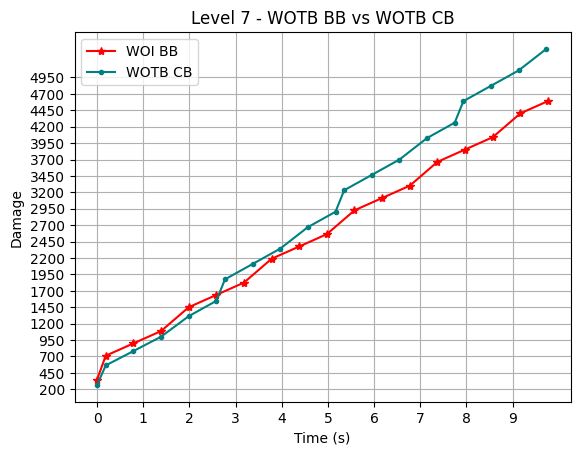

In [6]:
import matplotlib.pyplot as plt
plt.plot(bb_time_series, bb_damage_series, marker="*", label="WOI BB", color="red")
plt.plot(cb_time_series, cb_damage_series, marker='.', label="WOTB CB", color="teal")
plt.xlabel("Time (s)")
plt.ylabel("Damage")
plt.title("Level 7 - WOTB BB vs WOTB CB")
plt.legend()
plt.grid()
plt.xticks(range(0, 10, 1))
plt.yticks(range(200, 5000, 250))

plt.show()